In [149]:
# Must run this notebook from root directory in Anaconda for relative local file paths to work

Sys.time() # script start time

[1] "2018-08-09 15:08:23 AST"

# Install and attach packages

In [150]:
# See note at the end of this notebook regarding the preferred way of installing packages

In [151]:
library(tidyverse)

In [152]:
library(data.table)

In [153]:
library(stringr)

In [154]:
library(gridExtra)

In [155]:
library(sf) # needed for mapping

In [156]:
# install.packages("tmap")
# this for some reason can only be installed via install.packages(), but only has to be done once in your environment

In [157]:
library(tmap) # needed for mapping

In [158]:
# Set default options to display more digits, useful for gps coordinates

In [159]:
options(digits=15) # set the visible number of digits to 15, useful when displaying GIS coordinates in dataframes

In [160]:
options("digits") # display the max number of digits that appear in cells of a dataframe

$digits
[1] 15

In [161]:
sessionInfo()

R version 3.4.3 (2017-11-30)
Platform: x86_64-w64-mingw32/x64 (64-bit)
Running under: Windows 10 x64 (build 17134)

Matrix products: default

locale:
[1] LC_COLLATE=English_Canada.1252  LC_CTYPE=English_Canada.1252   
[3] LC_MONETARY=English_Canada.1252 LC_NUMERIC=C                   
[5] LC_TIME=English_Canada.1252    

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] bindrcpp_0.2         tmap_1.10            sf_0.5-4            
 [4] gridExtra_2.2.1      data.table_1.10.4-3  forcats_0.2.0       
 [7] stringr_1.2.0        dplyr_0.7.4          purrr_0.2.4         
[10] readr_1.1.1          tidyr_0.7.2          tibble_1.4.1        
[13] ggplot2_2.2.1        tidyverse_1.2.1      RevoUtils_10.0.8    
[16] RevoUtilsMath_10.0.1

loaded via a namespace (and not attached):
  [1] colorspace_1.3-2   deldir_0.1-14      class_7.3-14      
  [4] gdalUtils_2.0.1.7  leaflet_1.1.0      rgdal_1.2-8       
  [7] satellite_1

# Main Script Begins Here

## 5. Number of Transitional Homeless Beds at Female-Only Shelters Per 100,000 Female Population, 2017

In [162]:
Sys.time() # script start time from body

[1] "2018-08-09 15:08:23 AST"

In [163]:
# Import and clean data before analysis

In [164]:
# Import dataset
# Homeless Shelters in Canada
# Source: https://open.canada.ca/data/en/dataset/7e0189e3-8595-4e62-a4e9-4fed6f265e10
# See also: http://publications.gc.ca/collections/collection_2018/edsc-esdc/Em20-91-2018-eng.pdf


Sys.time() # start time for reading file
f <- function(x, pos) subset(x, 
                            !is.na(Beds)) # filter out any rows with missing values in the specified column in parenthesis
#                           & City == "Halifax") # only include rows where the specified condition is met
#                           & any other criteria for filtering
df <- read_csv_chunked("http://www.edsc-esdc.gc.ca/ouvert-open/hps/CDHPD-OpenDataNSPL-DataSet-20170804-ENFR.csv", 
                           DataFrameCallback$new(f), 
                           chunk_size = 50000, # this is an adequate chunk size
                           col_names = c("ShelterType", # this renames each column in order to what you specify
                                         "Province",
                                         "City",
                                         "TargetPopulation",
                                         "Gender",
                                         "ShelterName",
                                         "Beds"), # all other columns after this will be dropped
                           cols_only( # specify which columns with data types you want to include 
                                      # to avoid importing unwanted data
                                      # include all columns that you specified above with col_names
                               "ShelterType" = col_character(),
                               "Province" = col_character(),
                               "City" = col_character(),
                               "TargetPopulation" = col_character(),
                               "Gender" = col_character(),
                               "ShelterName" = col_character(),
                               "Beds" = col_number()),
                           skip = 1, # skip original column headers
                           trim_ws = TRUE) # trim leading and trailing whitespace for each data point
Sys.time() # end time for reading file

[1] "2018-08-09 15:08:24 AST"

[1] "2018-08-09 15:08:24 AST"

In [165]:
glimpse(df)

Observations: 687
Variables: 7
$ ShelterType      <chr> "Emergency", "Emergency", "Emergency", "Emergency"...
$ Province         <chr> "AB", "AB", "AB", "AB", "AB", "AB", "AB", "AB", "A...
$ City             <chr> "Calgary", "Calgary", "Calgary", "Calgary", "Calga...
$ TargetPopulation <chr> "Family", "General", "General", "General", "Genera...
$ Gender           <chr> "Both", "Both", "Both", "Both", "Both", "Both", "F...
$ ShelterName      <chr> "Brenda's House", "Calgary Alpha House", "Calgary ...
$ Beds             <dbl> 60, 120, 270, 975, 11, 370, 12, 6, 80, 25, 15, 5, ...


In [166]:
# drop the territories

df <- df %>%
  filter(!Province %in% c("NT", "NU", "YT")) %>%
  filter(ShelterType == "Transitional") %>%
  filter(Gender == "Female")

In [167]:
unique(df$Province)

[1] "AB" "BC" "MB" "NB" "NL" "NS" "ON" "QC" "SK"

In [168]:
# Always rename the columns to remove spaces and special characters if you haven't already from read_csv_chunked
# This avoids any potential problems R may encounter with different packages if not taken care of properly right away

# colnames(df) <- c(" ", " ")

In [169]:
# Always set the variable types next for each column and drop any unnecessary columns
# if you haven't already from read_csv_chunked, or need to change characters to factors
# use as.numeric() and as.factor() where appropriate
# df$column_name <- NULL will delete that column from the dataframe

df$ShelterType <- as.factor(df$ShelterType)
df$Province <- as.factor(df$Province)
df$City <- as.factor(df$City)
df$TargetPopulation <- as.factor(df$TargetPopulation)
df$Gender <- as.factor(df$Gender)

In [170]:
glimpse(df)
df

Observations: 52
Variables: 7
$ ShelterType      <fctr> Transitional, Transitional, Transitional, Transit...
$ Province         <fctr> AB, AB, AB, AB, AB, AB, AB, AB, BC, BC, BC, BC, M...
$ City             <fctr> Calgary, Calgary, Calgary, Edmonton, Edmonton, Ed...
$ TargetPopulation <fctr> General, General, Youth, General, General, Youth,...
$ Gender           <fctr> Female, Female, Female, Female, Female, Female, F...
$ ShelterName      <chr> "Youville Residence Society of Alberta", "YWCA - M...
$ Beds             <dbl> 37, 94, 6, 8, 24, 10, 15, 4, 14, 16, 10, 10, 5, 8,...


ShelterType,Province,City,TargetPopulation,Gender,ShelterName,Beds
Transitional,AB,Calgary,General,Female,Youville Residence Society of Alberta,37
Transitional,AB,Calgary,General,Female,YWCA - Mary Dover House,94
Transitional,AB,Calgary,Youth,Female,Boys and Girls Club - Haven's Way,6
Transitional,AB,Edmonton,General,Female,E4C Crossroads Downtown,8
Transitional,AB,Edmonton,General,Female,E4C Elizabeth House,24
Transitional,AB,Edmonton,Youth,Female,E4C Crossroads House,10
Transitional,AB,Lethbridge,General,Female,Native Women's Transition Home,15
Transitional,AB,Wood Buffalo,General,Female,Cecile's Place,4
Transitional,BC,Surrey,General,Female,Cynthia's Place Transitional,14
Transitional,BC,Vancouver,General,Female,Aboriginal Mother Centre Society - Transitional,16


In [171]:
unique(df$Province)

[1] AB BC MB NB NL NS ON QC SK
Levels: AB BC MB NB NL NS ON QC SK

In [172]:
glimpse(df)
head(df)
tail(df)

Observations: 52
Variables: 7
$ ShelterType      <fctr> Transitional, Transitional, Transitional, Transit...
$ Province         <fctr> AB, AB, AB, AB, AB, AB, AB, AB, BC, BC, BC, BC, M...
$ City             <fctr> Calgary, Calgary, Calgary, Edmonton, Edmonton, Ed...
$ TargetPopulation <fctr> General, General, Youth, General, General, Youth,...
$ Gender           <fctr> Female, Female, Female, Female, Female, Female, F...
$ ShelterName      <chr> "Youville Residence Society of Alberta", "YWCA - M...
$ Beds             <dbl> 37, 94, 6, 8, 24, 10, 15, 4, 14, 16, 10, 10, 5, 8,...


ShelterType,Province,City,TargetPopulation,Gender,ShelterName,Beds
Transitional,AB,Calgary,General,Female,Youville Residence Society of Alberta,37
Transitional,AB,Calgary,General,Female,YWCA - Mary Dover House,94
Transitional,AB,Calgary,Youth,Female,Boys and Girls Club - Haven's Way,6
Transitional,AB,Edmonton,General,Female,E4C Crossroads Downtown,8
Transitional,AB,Edmonton,General,Female,E4C Elizabeth House,24
Transitional,AB,Edmonton,Youth,Female,E4C Crossroads House,10


ShelterType,Province,City,TargetPopulation,Gender,ShelterName,Beds
Transitional,SK,Regina,Youth,Female,D.O.C.S. Place,6
Transitional,SK,Regina,Youth,Female,The Salvation Army Gemma House,4
Transitional,SK,Regina,Youth,Female,W.E.N.D.Y's House,6
Transitional,SK,Saskatoon,General,Female,YWCA Saskatoon Turning Points,15
Transitional,SK,Saskatoon,Youth,Female,Bethany Home,10
Transitional,SK,Saskatoon,Youth,Female,YWCA Saskatoon Margaret's Place,4


In [173]:
df_Provincial <- df %>%
  select(Province, Beds) %>%
  group_by(Province) %>%
  summarise(TotalTransitionalBedsForFemales = sum(Beds))

df_Provincial

Province,TotalTransitionalBedsForFemales
AB,198
BC,50
MB,5
NB,20
NL,12
NS,42
ON,129
QC,246
SK,66


In [174]:
# add row for one province that does not have emergency beds

newRow1 <- data.frame(Province = "PI", TotalTransitionalBedsForFemales = 0)

df_Provincial <- rbind(df_Provincial, newRow1)

df_Provincial

Province,TotalTransitionalBedsForFemales
AB,198
BC,50
MB,5
NB,20
NL,12
NS,42
ON,129
QC,246
SK,66
PI,0


In [175]:
# Add 2017 population stats for each province
# Source: https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000501&pickMembers%5B0%5D=1.10&pickMembers%5B1%5D=2.1

df_Provincial$TotalProvincialPopulationFemale <- 0

df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "AB"] <- 2117001
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "BC"] <- 2427673
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "MB"] <- 671339
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "NB"] <- 384250
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "NL"] <- 268207
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "NS"] <- 486028
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "ON"] <- 7212574
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "PI"] <- 77666
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "QC"] <- 4219609
df_Provincial$TotalProvincialPopulationFemale[df_Provincial$Province == "SK"] <- 577058


glimpse(df_Provincial)
df_Provincial

Observations: 10
Variables: 3
$ Province                        <fctr> AB, BC, MB, NB, NL, NS, ON, QC, SK...
$ TotalTransitionalBedsForFemales <dbl> 198, 50, 5, 20, 12, 42, 129, 246, 6...
$ TotalProvincialPopulationFemale <dbl> 2117001, 2427673, 671339, 384250, 2...


Province,TotalTransitionalBedsForFemales,TotalProvincialPopulationFemale
AB,198,2117001
BC,50,2427673
MB,5,671339
NB,20,384250
NL,12,268207
NS,42,486028
ON,129,7212574
QC,246,4219609
SK,66,577058
PI,0,77666


In [176]:
df_Provincial <- df_Provincial %>%
  mutate(TransitionalBedsForFemalesPer100K = round(TotalTransitionalBedsForFemales / TotalProvincialPopulationFemale * 100000))

glimpse(df_Provincial)
df_Provincial

Observations: 10
Variables: 4
$ Province                          <fctr> AB, BC, MB, NB, NL, NS, ON, QC, ...
$ TotalTransitionalBedsForFemales   <dbl> 198, 50, 5, 20, 12, 42, 129, 246,...
$ TotalProvincialPopulationFemale   <dbl> 2117001, 2427673, 671339, 384250,...
$ TransitionalBedsForFemalesPer100K <dbl> 9, 2, 1, 5, 4, 9, 2, 6, 11, 0


Province,TotalTransitionalBedsForFemales,TotalProvincialPopulationFemale,TransitionalBedsForFemalesPer100K
AB,198,2117001,9
BC,50,2427673,2
MB,5,671339,1
NB,20,384250,5
NL,12,268207,4
NS,42,486028,9
ON,129,7212574,2
QC,246,4219609,6
SK,66,577058,11
PI,0,77666,0


## Display a map of Canada showing results

In [177]:
CanadaMap <- st_read("GIS_Canada/lpr_000b16a_e.shp")

Reading layer `lpr_000b16a_e' from data source `C:\Users\rahmant\GIS_Canada\lpr_000b16a_e.shp' using driver `ESRI Shapefile'
Simple feature collection with 13 features and 6 fields
geometry type:  MULTIPOLYGON
dimension:      XY
bbox:           xmin: 3689439 ymin: 659338.9 xmax: 9015737 ymax: 5242179
epsg (SRID):    NA
proj4string:    +proj=lcc +lat_1=49 +lat_2=77 +lat_0=63.390675 +lon_0=-91.86666666666666 +x_0=6200000 +y_0=3000000 +datum=NAD83 +units=m +no_defs


In [178]:
Sys.time()
glimpse(CanadaMap)
Sys.time()

[1] "2018-08-09 15:08:25 AST"

Observations: 13
Variables: 7
$ PRUID    <fctr> 10, 11, 12, 13, 24, 35, 46, 47, 48, 59, 60, 61, 62
$ PRNAME   <fctr> Newfoundland and Labrador / Terre-Neuve-et-Labrador, Prin...
$ PRENAME  <fctr> Newfoundland and Labrador, Prince Edward Island, Nova Sco...
$ PRFNAME  <fctr> Terre-Neuve-et-Labrador, Île-du-Prince-Édouard, Nouvelle-...
$ PREABBR  <fctr> N.L., P.E.I., N.S., N.B., Que., Ont., Man., Sask., Alta.,...
$ PRFABBR  <fctr> T.-N.-L., Î.-P.-É., N.-É., N.-B., Qc, Ont., Man., Sask., ...
$ geometry <simple_feature> MULTIPOLYGON (((8307365.588..., MULTIPOLYGON ((...


[1] "2018-08-09 15:08:49 AST"

In [179]:
# Sys.time()
# CanadaMap
# Sys.time()

In [180]:
# Add a column for PREABBR to df_Provincial in order to do a join with CanadaMap


df_Provincial$PREABBR <- "unknown"

df_Provincial$PREABBR[df_Provincial$Province == "AB"] <- "Alta."
df_Provincial$PREABBR[df_Provincial$Province == "BC"] <- "B.C."
df_Provincial$PREABBR[df_Provincial$Province == "MB"] <- "Man."
df_Provincial$PREABBR[df_Provincial$Province == "NB"] <- "N.B."
df_Provincial$PREABBR[df_Provincial$Province == "NL"] <- "N.L."
df_Provincial$PREABBR[df_Provincial$Province == "NS"] <- "N.S."
df_Provincial$PREABBR[df_Provincial$Province == "ON"] <- "Ont."
df_Provincial$PREABBR[df_Provincial$Province == "PI"] <- "P.E.I."
df_Provincial$PREABBR[df_Provincial$Province == "QC"] <- "Que."
df_Provincial$PREABBR[df_Provincial$Province == "SK"] <- "Sask."

df_Provincial$PREABBR <- as.factor(df_Provincial$PREABBR)
glimpse(df_Provincial)
df_Provincial

Observations: 10
Variables: 5
$ Province                          <fctr> AB, BC, MB, NB, NL, NS, ON, QC, ...
$ TotalTransitionalBedsForFemales   <dbl> 198, 50, 5, 20, 12, 42, 129, 246,...
$ TotalProvincialPopulationFemale   <dbl> 2117001, 2427673, 671339, 384250,...
$ TransitionalBedsForFemalesPer100K <dbl> 9, 2, 1, 5, 4, 9, 2, 6, 11, 0
$ PREABBR                           <fctr> Alta., B.C., Man., N.B., N.L., N...


Province,TotalTransitionalBedsForFemales,TotalProvincialPopulationFemale,TransitionalBedsForFemalesPer100K,PREABBR
AB,198,2117001,9,Alta.
BC,50,2427673,2,B.C.
MB,5,671339,1,Man.
NB,20,384250,5,N.B.
NL,12,268207,4,N.L.
NS,42,486028,9,N.S.
ON,129,7212574,2,Ont.
QC,246,4219609,6,Que.
SK,66,577058,11,Sask.
PI,0,77666,0,P.E.I.


In [181]:
# Add a column for Year

df_Provincial$Year <- 2017

In [182]:
# Before merging with a shapefile for polygon data, write the data to a table in csv format
# Table_B

write.csv(df_Provincial, 
          file = "Table_E.csv",
          row.names = FALSE) # set row.name to FALSE to not include an index column in the csv output file

In [183]:
# Save a dataframe as a nicely formatted png file
# uses the gridExtra package

png("Table_E.png", height = 30*nrow(df_Provincial), width = 150*ncol(df_Provincial))
grid.table(df_Provincial)
dev.off()

png 
  2

In [184]:
CanadaMap <- merge(CanadaMap, df_Provincial) # join the two dataframes, merge will use the common column name to join with

In [185]:
Sys.time()
glimpse(CanadaMap)
Sys.time()

[1] "2018-08-09 15:08:51 AST"

Observations: 10
Variables: 12
$ PREABBR                           <fctr> Alta., B.C., Man., N.B., N.L., N...
$ PRUID                             <fctr> 48, 59, 46, 13, 10, 12, 35, 11, ...
$ PRNAME                            <fctr> Alberta, British Columbia / Colo...
$ PRENAME                           <fctr> Alberta, British Columbia, Manit...
$ PRFNAME                           <fctr> Alberta, Colombie-Britannique, M...
$ PRFABBR                           <fctr> Alb., C.-B., Man., N.-B., T.-N.-...
$ Province                          <fctr> AB, BC, MB, NB, NL, NS, ON, PI, ...
$ TotalTransitionalBedsForFemales   <dbl> 198, 50, 5, 20, 12, 42, 129, 0, 2...
$ TotalProvincialPopulationFemale   <dbl> 2117001, 2427673, 671339, 384250,...
$ TransitionalBedsForFemalesPer100K <dbl> 9, 2, 1, 5, 4, 9, 2, 0, 6, 11
$ Year                              <dbl> 2017, 2017, 2017, 2017, 2017, 201...
$ geometry                          <simple_feature> MULTIPOLYGON (((522830...


[1] "2018-08-09 15:09:06 AST"

[1] "2018-08-09 15:09:06 AST"

[1] "2018-08-09 15:09:47 AST"

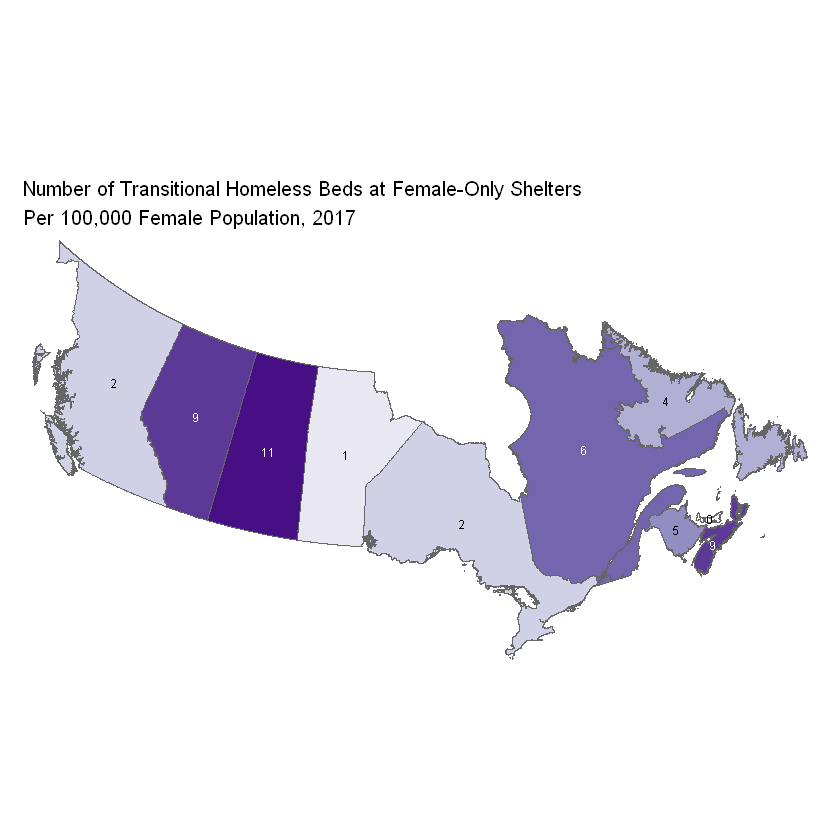

In [186]:
Sys.time()

my_map_E0 <-
  tm_shape(CanadaMap) +
  tm_polygons(col = "TransitionalBedsForFemalesPer100K", palette = "Purples", style = "order") +
  tm_legend(legend.outside = TRUE, legend.outside.position = "bottom") +
  tm_text(text = "TransitionalBedsForFemalesPer100K", size = .6) + 
  tm_layout(frame = FALSE, 
            legend.show = FALSE,
            main.title = "Number of Transitional Homeless Beds at Female-Only Shelters\nPer 100,000 Female Population, 2017",
            main.title.size = 1)

my_map_E0

Sys.time()

In [187]:
# Sys.time()
#   save_tmap(tm = my_map_E0, 
#             filename = "Number of Transitional Homeless Beds at Female-Only Shelters Per 100,000 Female Population, 2017.png")
# Sys.time()

# Main Script Ends Here

In [188]:
Sys.time()

[1] "2018-08-09 15:09:51 AST"

# Appendix 1 - Examples of common coding techniques

In [189]:
# Example of how to read and filter a large csv file a chunk at a time, e.g. filter 50000 rows at a time into a new dataframe
# This is very efficient, comparable to fread in speed but done in chunks to conserve memory
# I also prefer it to fread because I can filter out rows with missing values as I import the data
# and specify which columns I want to import 
# need readr library from tidyverse library


# Sys.time() # start time for reading file
# f <- function(x, pos) subset(x, 
#                             !is.na(Beds) # filter out any rows with missing values in the specified column in parenthesis
#                             & Gender == "Male") # only include rows where the specified condition is met
#                             & any other criteria for filtering
# df <- read_csv_chunked("http://www.edsc-esdc.gc.ca/ouvert-open/hps/CDHPD-OpenDataNSPL-DataSet-20170804-ENFR.csv", 
#                            DataFrameCallback$new(f), 
#                            chunk_size = 50000, # this is an adequate chunk size
#                            # col_names = TRUE # this will keep original column names if you don't provide custom names
#                                               # most of the time it's best to rename every column explicitly as shown below
#                            col_names = c("ShelterType", # this renames each column in order of the csv file to what you specify
#                                          "ProvinceCode",
#                                          "City",
#                                          "TargetPopulation",
#                                          "Gender",
#                                          "ShelterName",
#                                          "Beds"), # all other columns after this will be dropped if not included        
#                            cols_only( # specify which columns with data types you want to include 
#                                       # to avoid importing unwanted data
#                                       # include all columns that you specified above with col_names if you renamed them
#                                "ShelterType" = col_character(),
#                                "ProvinceCode" = col_character(),
#                                "City" = col_character(),
#                                "TargetPopulation" = col_character(),
#                                "Gender" = col_character(),
#                                "ShelterName" = col_character(),
#                                "Beds" = col_number()),
#                            skip = 1, # skip original column headers if you renamed them
#                            trim_ws = TRUE) # trim leading and trailing whitespace for each data point
# Sys.time() # end time for reading file

In [190]:
# Example of how to read csv files quickly with fread while converting all chr variables to factors 
# need data.table library
# Use fread when you are a lazy and know you won't have memory issues loading the entire dataset at once
# or when you know you need to keep all information loaded into memory

# df <- fread("DataFilesAOP/AB_Provincial_Detailed_Crime_Stats_2006-2011-2016.csv", 
#            stringsAsFactors = TRUE, header = TRUE)

In [191]:
# Example of how to write a dataframe to a csv file

# write.csv(df, 
#           file = "NS_Crime_Stats_Clean_Extract3.csv",
#           row.names = FALSE) # set row.name to FALSE to not include an index column in the csv output file

In [192]:
# Example how to change all of the column names in a dataframe to something friendlier
# You want to avoid special characters and spaces in column names to prevent problems with differnt packages and features
# Provide new names in a character vector

# colnames(df) <- c(" ", " ")

In [193]:
# Example of how to rename a specific column in a dataframe

# names(df)[names(df) == "PercentageOfDeaths"] <- "PercentageOfDeathsMale"

In [194]:
# Example of how to view specific columns from a dataframe

# df[, c("BedsPer100K", "PercentageOfDeathsMale")]

In [195]:
# Example how to set the number of digits displayed in dataframes

# options(digits=15) # set the visible number of digits to 15, useful when displaying GIS coordinates in dataframes
# options("digits") # display the max number of digits that appear in cells of a dataframe

In [196]:
# Example of how to convert columns to the correct data types and how to delete columns from a dataframe

# use as.numeric() and as.factor() where appropriate
# df$column_name <- NULL will delete that column from the dataframe

In [197]:
# Example of how to recode values of a column for rows meeting a condition

# df$LATITUDE[df$GEO == 
#                          "Amherst, Nova Scotia, municipal"] <- 45.8338198
# df$LONGITUDE[df$GEO == 
#                          "Amherst, Nova Scotia, municipal"] <- -64.2109455
#
# df$COUNTY[df$GEO ==
#                          "Amherst, Nova Scotia, municipal"] <- "Cumberland"

In [198]:
# Example of how to filter a dataframe to rows where a specific string appears anywhere in a specific column
# This example filters df to rows where "MEP" appears in the "Contents" column (need stringr library)

# df_MEP <- df %>%
#   filter(str_detect(Contents, "MEP"))

In [199]:
# Example of how to handle dates - converting from timestamp to YYYYMMDD
# This example is adequate if you really don't need a date field for arithmetic or plotting with ggplot2

# parse out date and time from Timestamp
# df <- 
#   separate(df, Timestamp, # e.g., "01/01/2017 12:00:00 AM"
#           into = c("Date", "Time", "AMPM"), sep = " ")

# parse out Month, Day, Year from Date
# df <- 
#  separate(df, Date, 
#           into = c("Month", "Day", "Year"), sep = "/")

# Remove unwanted columns
# df$Time <- NULL
# df$AMPM <- NULL

# unite the columns "Year", "Month", "Day" into a single column for "YYYYMMDD"
# df <- 
#  unite_(df, "YYYYMMDD", c("Year","Month", "Day"), sep = "")

# sort by date in decreasing order
# df <- df[order(df$YYYYMMDD, decreasing = TRUE), ]

In [200]:
# Use the lubridate library if arithmetic is important when working with date and time data
# In my opinion, the lubridate functions are more complicated than my current needs, so I prefer my approach above
# for handling dates/times

# https://lubridate.tidyverse.org/
# https://rawgit.com/rstudio/cheatsheets/master/lubridate.pdf

In [201]:
# Example of how to subset and retain only selected characters from a cell
# This is useful if you want to strip out useless characters in a cell given a start and end position to retain
# need stringr library

# df$gps <- 
#   str_sub(df$gps, start = 3, end = -2) 

# this gets rid of the first 3 characters and the last two characters
# you can get an accurate count of characters when viewing them with glimpse(df)

In [202]:
# Example how to merge two dataframes on common column names
# https://stackoverflow.com/questions/1299871/how-to-join-merge-data-frames-inner-outer-left-right

# CanadaMap <- merge(CanadaMap, df_Provincial) # join the two dataframes, merge will use the common column name to join with

In [203]:
# Example of how to combine two or more dataframes vertically with the same column names

# df4 <- rbind(df1, df2, df3)

In [204]:
# Example of how to combine two or more dataframes horizontally with the same number of rows but different columns

# df4 <- cbind(df1, df2, df3)

In [205]:
# Example of how to create a new column that takes on values by performing arithmetic on existing columns 
# need dplyr and tidyverse library
# This example creates a new column that divides one column by another and mutliplies the result by a constant

# NSMAP2011 <- NSMAP2011 %>%
#   mutate(PropertyCrimeCountyRatePer100K = PropertyCrimeIncidentsPerCounty/CountyPopulation * 100000)

In [206]:
# Example of how to order a dataframe by a column in descening order
# a "-" in front of the column name will sort it in descending (largest to lowest) order

# df <- 
#  df[with(df, order(-Incidents_Total)), ]


# adding multiple column names will prioritize ordering in that sequence

# df <- 
#  df[with(df, order(REGION, COUNTY, GEO, Violations, Statistics)), ]

#--------------------
# Alternatively, you can also use the following:
# sort by date in decreasing order
# df <- df[order(df$YYYYMMDD, decreasing = TRUE), ]

In [207]:
# Before spreading data for tidy format, make sure to remove any special characters beforehand
# This ensures that after spreading the data, the column names are all properly formatted
# Properly formatted column names will always appear flushed next to the dollar sign when glimpsing a dataframe
# If spaces or special characters are present in the column name, they will appear within single quotes after the dollar sign
# when glimpsing the dataframe after spreading the data

# df_health$Indicators <- gsub(" ", "_", df_health$Indicators)
# df_health$Indicators <- gsub(",", "", df_health$Indicators)
# df_health$Indicators <- gsub(";", "", df_health$Indicators)
# df_health$Indicators <- gsub("-", "_", df_health$Indicators)
# df_health$Indicators <- gsub("\\(", "", df_health$Indicators) # this removes left parenthesis
# df_health$Indicators <- gsub("\\)", "", df_health$Indicators) # this removes right parenthesis

# df_health <- df_health %>%
#   spread(Indicators, Value)

In [208]:
# Example of how to load a shapefile for mapping 
# need sf library

# NS <- st_read("GIS_Nova_Scotia/Counties_GCS.shp")

In [209]:
# Example how to convert a dataframe of lats/longs to a an sf dataframe for points spatial data 
# need sf library

# pts <- st_as_sf(df, coords = c("LONGITUDE", "LATITUDE"), crs = 4269) # create sf object called "pts" from df
# class(pts)
# glimpse(pts) # LONGITUDE and LATITUDE columns are replaced with a geometry column for point data

In [210]:
# Example how to add custom icons for points spatial data 
# need sf library and tmap library

# Using custom icons for points instead of bubbles

# file <- "DataFilesGeneral/flower_960_720.png"  
# flower_icon <- tmap_icons(file, width = 48, height = 48, keep.asp = TRUE,
#   just = c("center", "center"), as.local = TRUE)

# my_map_2 <- my_map_0 +
#   tm_shape(pts) +
#   tm_symbols("VALUE", shape = flower_icon, size = .3, alpha = .2, border.alpha = 0) 
# my_map_2

# Appendix 2 - Note regarding preferred way for installing packages

In [211]:
# Preferrably, install new packages via Anaconda Prompt > conda install r-package_name
# Try to only use library() in notebook instead of install.packages()
# this is more reliable than using install.packages("package name") in R script
# Anaconda Prompt > conda list shows what packages are installed

# However, when the above isn't true for some reason, it is noted below
# e.g., tmap must be installed through install.packages("tmap")